In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# Importar Datos xlsx (Primera fila nombres de columnas)
data = pd.read_excel('Tarea 2-202420.xlsx', header=1)

# Crear DataFrame
df = pd.DataFrame(data)

# Mostrar DataFrame
print(df.head())

# Características de los drones
autonomia = 12 # Horas
velocidad = 1000  # metros/min
distancia_maxima = autonomia * 60 * velocidad

# Conjuntos
Lugares = list(range(26))  # 25 cultivos más el hangar (L = {0,1,2,...,25}).
Drones = [1, 2, 3, 4, 5]  # Conjunto de drones.
A = [(i, j) for i in Lugares for j in Lugares if i != j] # Lista de arcos entre lugares (Con distancia máxima permitida).

# Parametros
# Distancias entre los lugares (distancia Manhattan)
q = {(i, j): np.abs(df["Calle"][i] - df["Calle"][j]) + np.abs(df["Carrera"][i] - df["Carrera"][j]) for i, j in A}

# Filtro de lugares que no cumplen con la distancia máxima permitida
A = [(i, j) for i, j in A if q[i, j] <= distancia_maxima]

# Crear el modelo
m = gp.Model('Opti-Drones')



# Variables de decisión
# x[d, i, j] = 1 si el dron d viaja de lugar i a lugar j, 0 en caso contrario
x = m.addVars(Drones, A, vtype=GRB.BINARY, name='x')
# Variables auxiliares u para eliminación de subtours (Miller-Tucker-Zemlin)
u = m.addVars(Drones, Lugares, vtype=GRB.CONTINUOUS, name='u')



# Función objetivo: Minimizar la distancia total recorrida por todos los drones
m.setObjective(gp.quicksum(q[i, j] * x[d, i, j] for d in Drones for i, j in A), GRB.MINIMIZE)



# Restricciones
# Restricción 1: Todo cultivo debe ser visitado por exactamente un dron (llega a i)
for i in Lugares:
    if i != 0:  # El hangar no cuenta
        m.addConstr(gp.quicksum(x[d, j, i] for d in Drones for j in Lugares if (j, i) in A) == 1)

# Restricción 2: Todo cultivo debe ser visitado por exactamente un dron (sale de i)
for i in Lugares:
    if i != 0:  # El hangar no cuenta
        m.addConstr(gp.quicksum(x[d, i, j] for d in Drones for j in Lugares if (i, j) in A) == 1)

# Restricción 3: Cada dron debe realizar exactamente un viaje desde y hacia el hangar
for d in Drones:
    m.addConstr(gp.quicksum(x[d, 0, j] for j in Lugares if (0, j) in A) == 1)  # Salida del hangar
    m.addConstr(gp.quicksum(x[d, i, 0] for i in Lugares if (i, 0) in A) == 1)  # Regreso al hangar

# Restricción 4: Balance en cada nodo (número de arcos que entran = número de arcos que salen para cada dron)
for d in Drones:
    for i in Lugares:
        if i != 0:
            m.addConstr(gp.quicksum(x[d, i, j] for j in Lugares if (i, j) in A) == 
                        gp.quicksum(x[d, j, i] for j in Lugares if (j, i) in A))
            
# Restricción 5: La ruta de cada dron debe ser un ciclo que no supere la distancia máxima
for d in Drones:
    m.addConstr(gp.quicksum(q[i, j] * x[d, i, j] for i, j in A) <= distancia_maxima)

# Prohibir subtours de tamaño 2 para cada dron
for d in Drones:
    for i in Lugares:
        for j in Lugares:
            if i != j:
                m.addConstr(x[d, i, j] + x[d, j, i] <= 1)

# Restricciones MTZ (para evitar subtours mayores para cada dron)
for d in Drones:
    for i in Lugares:
        for j in Lugares:
            if i != j and i != 0 and j != 0:
                m.addConstr(u[d, i] - u[d, j] + len(Lugares) * x[d, i, j] <= len(Lugares) - 1)

# Optimizar el modelo
m.optimize()

       Lugar  Calle  Carrera  Fotos a tomar
0     Hangar     40       80              0
1  Cultivo 1     39       59             50
2  Cultivo 2      8       82             30
3  Cultivo 3      8       53             55
4  Cultivo 4     29       45             30
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-23
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6440 rows, 3380 columns and 31500 nonzeros
Model fingerprint: 0x555f1b59
Variable types: 130 continuous, 3250 integer (3250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [1e+00, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Found heuristic solution: objective 926.0000000
Presolve removed 1630 rows and 5 colum

In [2]:
# Imprimir la solución para cada dron

print("Distancia Maxima Permitida: ", distancia_maxima)

for d in Drones:
    SumaFotos = 0
    SumaDistancia = 0
    print(f"\nRutas del dron {d}:")
    for i, j in A:
        if x[d, i, j].x > 0.5:
            print(f"Dron {d} va de {i} a {j}")
            SumaFotos += df["Fotos a tomar"][j]
            SumaDistancia += q[i, j]
    print(f"Total de fotos a tomar: {SumaFotos}")
    print(f"Distancia total recorrida: {SumaDistancia}")


Distancia Maxima Permitida:  720000

Rutas del dron 1:
Dron 1 va de 0 a 24
Dron 1 va de 20 a 0
Dron 1 va de 24 a 20
Total de fotos a tomar: 70
Distancia total recorrida: 46

Rutas del dron 2:
Dron 2 va de 0 a 18
Dron 2 va de 13 a 0
Dron 2 va de 18 a 13
Total de fotos a tomar: 165
Distancia total recorrida: 22

Rutas del dron 3:
Dron 3 va de 0 a 9
Dron 3 va de 9 a 22
Dron 3 va de 22 a 0
Total de fotos a tomar: 130
Distancia total recorrida: 38

Rutas del dron 4:
Dron 4 va de 0 a 11
Dron 4 va de 2 a 10
Dron 4 va de 3 a 6
Dron 4 va de 4 a 12
Dron 4 va de 5 a 19
Dron 4 va de 6 a 15
Dron 4 va de 7 a 0
Dron 4 va de 8 a 4
Dron 4 va de 10 a 7
Dron 4 va de 11 a 8
Dron 4 va de 12 a 14
Dron 4 va de 14 a 21
Dron 4 va de 15 a 25
Dron 4 va de 16 a 5
Dron 4 va de 19 a 2
Dron 4 va de 21 a 23
Dron 4 va de 23 a 3
Dron 4 va de 25 a 16
Total de fotos a tomar: 740
Distancia total recorrida: 180

Rutas del dron 5:
Dron 5 va de 0 a 17
Dron 5 va de 1 a 0
Dron 5 va de 17 a 1
Total de fotos a tomar: 60
Distanci

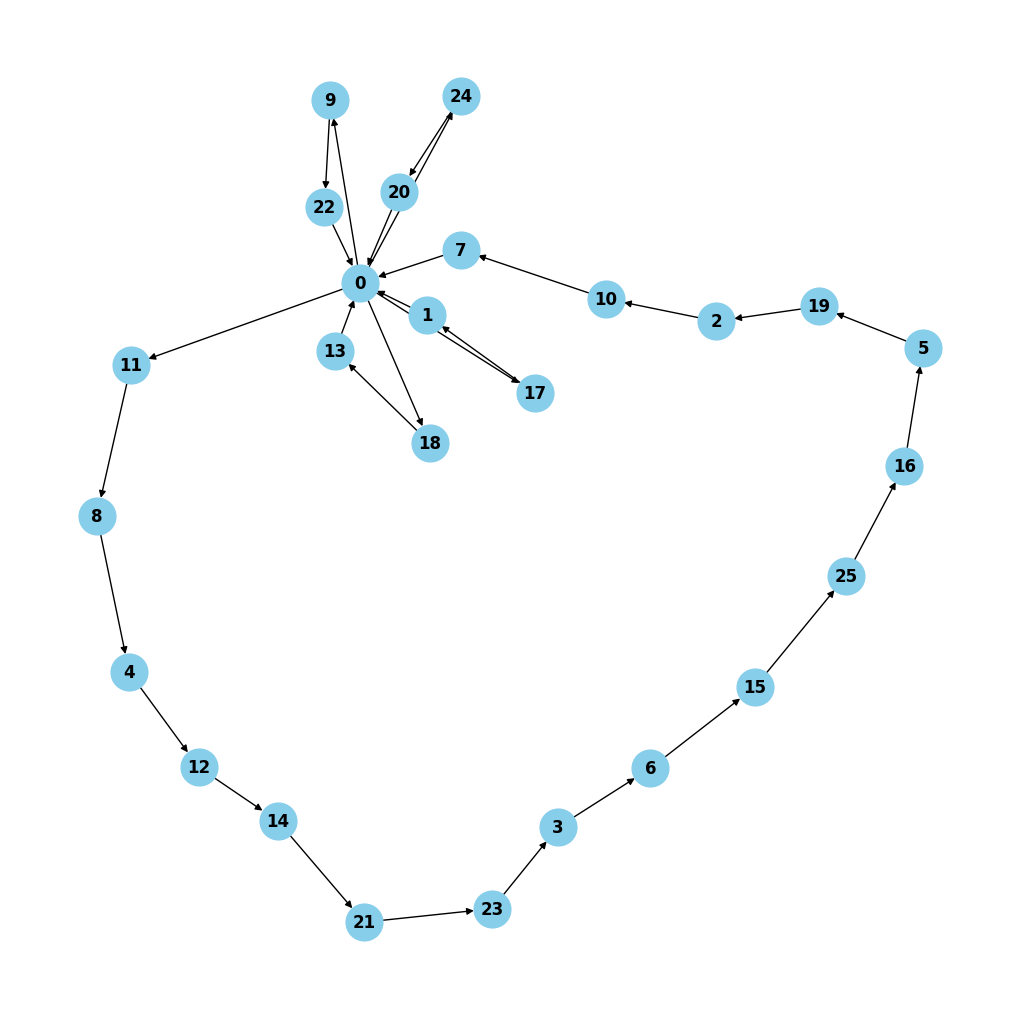

In [9]:
# Dibujar grafo de la solución (colocando nodos adyacentes más cerca)
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

# Agregar las aristas del grafo
for i, j in A:
    for d in Drones:
        if x[d, i, j].x > 0.5:
            G.add_edge(i, j)

# Ajuste del layout con resorte (spring_layout)
# Aquí 'k' controla la distancia entre nodos. Valores más pequeños hacen que los nodos estén más cerca.
# Aumentar las iteraciones para un ajuste más preciso.
pos = nx.spring_layout(G, k=0.6, iterations=150)  # Ajustar k para reducir la distancia entre nodos adyacentes

# Dibujar los nodos y arcos del grafo
plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura para mayor claridad
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=12, font_weight='bold')

# Si tienes etiquetas para los arcos, por ejemplo, las distancias recorridas
labels = nx.get_edge_attributes(G, 'weight')

# Dibujar etiquetas de los arcos si existen
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Mostrar el grafo
plt.show()
